In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime
from scipy.signal import savgol_filter

# hide warnings
import warnings
warnings.filterwarnings('ignore')
print('done');

done


In [2]:
# All countries data
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('').drop(['Lat', 'Long'], axis=1)
death_table = death_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('').drop(['Lat', 'Long'], axis=1)
recovered_table = recovered_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('').drop(['Lat', 'Long'], axis=1)

full_table = confirmed_table.merge(death_table).merge(recovered_table)

full_table['Date'] = pd.to_datetime(full_table['Date'])

# cases 
#cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# replacing 'Korea, South' with South Korea
full_table['Country/Region'] = full_table['Country/Region'].replace('Korea, South','South Korea')

# replacing 'Korea, South' with South Korea
full_table['Country/Region'] = full_table['Country/Region'].replace('United Kingdom','UK')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
# full_table[cases] = full_table[cases].fillna(0)

full_table.tail(10)

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered,Active
32246,,Malawi,2020-05-28,203,4,37,162
32247,Falkland Islands (Malvinas),UK,2020-05-28,13,0,13,0
32248,Saint Pierre and Miquelon,France,2020-05-28,1,0,1,0
32249,,South Sudan,2020-05-28,994,10,6,978
32250,,Western Sahara,2020-05-28,9,1,6,2
32251,,Sao Tome and Principe,2020-05-28,458,12,68,378
32252,,Yemen,2020-05-28,278,57,11,210
32253,,Comoros,2020-05-28,87,2,24,61
32254,,Tajikistan,2020-05-28,3563,47,1674,1842
32255,,Lesotho,2020-05-28,2,0,1,1


In [3]:
# All US states and counties data
county_data = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
county_data[county_data['county'] == 'New York City'].tail(10)

,date,county,state,fips,cases,deaths
157768,2020-05-19,New York City,New York,NaN,198710,20376
160716,2020-05-20,New York City,New York,NaN,199392,20422
163667,2020-05-21,New York City,New York,NaN,200507,20491
166623,2020-05-22,New York City,New York,NaN,201298,20569
169584,2020-05-23,New York City,New York,NaN,202062,20621
172547,2020-05-24,New York City,New York,NaN,202931,20697
175512,2020-05-25,New York City,New York,NaN,203569,20740
178477,2020-05-26,New York City,New York,NaN,204111,20795
181447,2020-05-27,New York City,New York,NaN,204781,20844
184425,2020-05-28,New York City,New York,NaN,205854,20895


In [4]:
def time_series_state(state):
    state_table  = pd.DataFrame(county_data[county_data['state'] == state],columns=['date','cases','deaths']).groupby('date')['cases','deaths'].sum();
    state_table.rename(columns={"cases":"Confirmed","deaths":"Deaths"},inplace='True');
    return state_table;

def time_series_county(county):
    county_table = pd.DataFrame(county_data[county_data['county']] == county, columns=['date','cases','deaths']).groupy('date')['cases','deaths'].sum();
    county_table.rename(columns={"cases":"Confirmed","deaths":"Deaths"},inplace='True');
    return county_table;

In [5]:
def get_time_series(country):
    # for some countries, data is spread over several Provinces
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed', 'Deaths', 'Recovered'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered']]


def get_time_series_province(province):
    # for some countries, data is spread over several Provinces
    df = full_table[(full_table['Province/State'] == province)]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered']]


In [37]:
%debug

> /Users/tanviranjan/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py(602)polyfit()
    600         raise TypeError("expected 1D or 2D array for y")
    601     if x.shape[0] != y.shape[0]:
--> 602         raise TypeError("expected x and y to have same length")
    603 
    604     # set rcond

ipdb> np.diff(tt2[tt3:]
*** SyntaxError: unexpected EOF while parsing
ipdb> q


In [64]:
# Number of cases

def plot_time_series(clist,chart_idx):
    n=np.size(clist); color = cm.jet(np.linspace(0,1,n)) 
    min_case=100; min_death=10;
    
    
    plt.figure(figsize=(20,20))
    for i,c in zip(range(n),color):
        if chart_idx == 1:
            place = clist[i]; #print(country)
            df = get_time_series(place); 
        else:
            place = clist[i];
            df = time_series_state(place); 
                
        
        if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
            df.drop(df.tail(1).index,inplace=True)
        kk=df[['Confirmed']]; kk2=kk.to_numpy();kk3=np.argmax(kk2>min_case);
        plt.subplot(221); plt.plot(range(np.size(kk2[kk3:])),kk2[kk3:],c=c,label=place,marker='.'); plt.yscale('log');
        #plt.text(np.size(kk2[kk3:]),kk2[np.size(kk2)-1],place,fontsize=15,color=c);
        #plt.text(i,i,place,fontsize=15,color=c);

        tt=df[['Deaths']]; tt2=tt.to_numpy(); tt3=np.argmax(tt2>min_death);
        plt.subplot(222); plt.plot(range(np.size(tt2[tt3:])),tt2[tt3:],c=c,label=place,marker='.'); plt.yscale('log');
        #plt.text(np.size(tt2[tt3:]),tt2[np.size(tt2)-1],place,fontsize=15,color=c);

        fatality_rate=np.divide(tt2[tt3:],kk2[tt3:]);
        plt.subplot(223); plt.plot(range(np.size(tt2[tt3:])),fatality_rate,c=c,marker='.'); plt.yscale('log');
        #plt.text(np.size(tt2[tt3:]),fatality_rate[np.size(fatality_rate)-1],place,fontsize=15,color=c);

        daily_death=savgol_filter((np.diff(tt2[tt3:],axis=0)).T,7,1).T; 
        plt.subplot(224); plt.plot(range(np.size(tt2[tt3:])-1),daily_death,c=c,marker='.'); plt.yscale('log');
        #plt.text(np.size(tt2[tt3:])-1,daily_death[np.size(daily_death)-1],place,fontsize=15,color=c);

    plt.subplot(221); plt.legend();    
    plt.subplot(221); plt.xlabel('Days since ' + str(min_case) +'th case',fontsize=20); plt.title('Confirmed cases',fontsize=20)
    plt.subplot(222); plt.xlabel('Days since ' + str(min_death) +'th death',fontsize=20); plt.title('Deaths',fontsize=20)
    plt.subplot(223); plt.xlabel('Days since ' + str(min_death) +'th death',fontsize=20); plt.title('Death per case',fontsize=20)
    plt.subplot(224); plt.xlabel('Days since ' + str(min_death) +'th death',fontsize=20); plt.title('Daily deaths',fontsize=20)


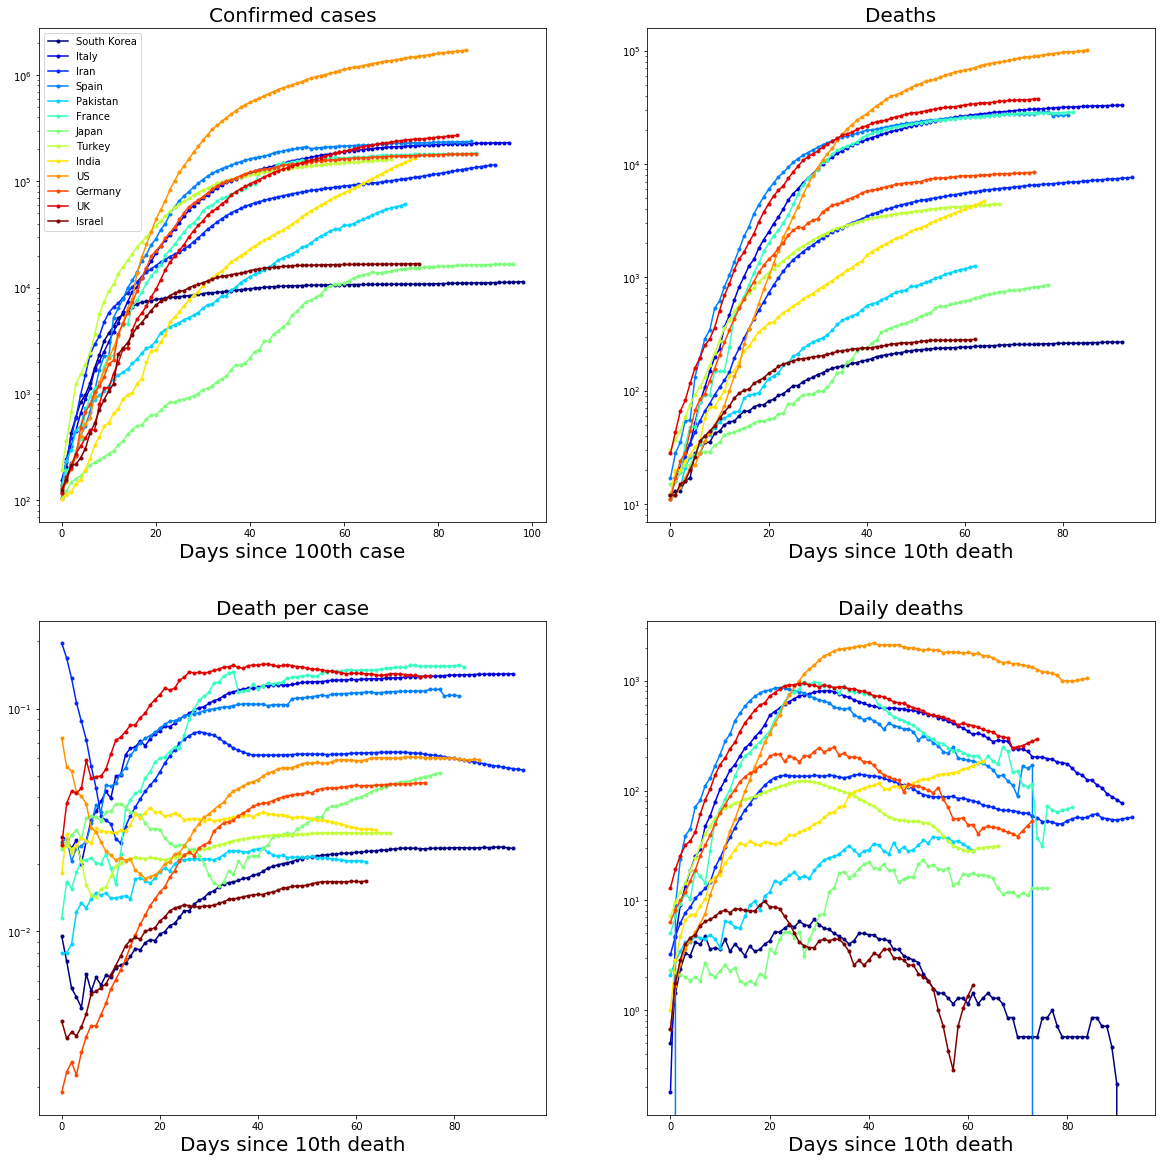

In [65]:
#clist=np.array(['Georgia','New York','Washington','California','New Jersey','Massachusetts','Florida','Michigan','Louisiana','Illinois'])
clist=np.array(['South Korea','Italy','Iran','Spain','Pakistan','France','Japan','Turkey','India','US','Germany','UK','Israel']);
plot_time_series(clist,1);

In [43]:
%debug


> <ipython-input-38-d214fa6ed93d>(33)plot_time_series()
     31         #plt.text(np.size(tt2[tt3:]),fatality_rate[np.size(fatality_rate)-1],place,fontsize=15,color=c);
     32 
---> 33         x
     34         daily_death=savgol_filter(np.diff(tt2[tt3:],axis=0),7,1);
     35         plt.subplot(224); plt.plot(range(np.size(tt2[tt3:])-1),daily_death,c=c,marker='.'); plt.yscale('log');

ipdb> np.diff(tt2[tt3:]
*** SyntaxError: unexpected EOF while parsing
ipdb> np.diff(tt2[tt3:],axis=0)
array([[ 1],
       [ 0],
       [ 3],
       [ 1],
       [11],
       [ 0],
       [ 7],
       [ 0],
       [ 7],
       [ 2],
       [ 6],
       [ 3],
       [ 1],
       [ 6],
       [ 6],
       [ 0],
       [ 6],
       [ 3],
       [ 0],
       [ 6],
       [ 3],
       [ 7],
       [ 3],
       [ 8],
       [ 9],
       [ 0],
       [ 9],
       [ 6],
       [ 5],
       [ 8],
       [ 5],
       [ 8],
       [ 6],
       [ 4],
       [ 3],
       [ 4],
       [ 5],
       [ 3],
       [ 6],
 

In [59]:
#TO DO:
# Scrape data
# Calculate cases/test and test/population - to get a measure of how many untested cases might be. Could be both - time series and final number
# Make a struct version of the data so source can be delineated

In [8]:
#!pip install selenium
#!pip install bs4
from selenium import webdriver
from bs4 import BeautifulSoup

In [9]:
driver = webdriver.Chrome('/Users/tanviranjan/Downloads/chromedriver 3');
driver.get('https://www.worldometers.info/coronavirus/');
content = driver.page_source;
soup = BeautifulSoup(content);
total_cases=[]; new_cases=[]; total_deaths=[]; new_deaths=[]; total_tests=[];
total_case_per1m=[]; deaths_per1m=[]; tests_per1m=[];

In [13]:
content = driver.page_source;
soup = BeautifulSoup(content);
k=1;
for a in soup.findAll('table',href=True,attrs={'class':'table table-bordered table-hover main_table_countries dataTable no-footer'}):
    print(k);k=k+1; name=a.find('tr', attrs={'class':'even' 'odd'}); print(name)

soup.findAll('tr',href=True,attrs={'class':'table table-bordered table-hover main_table_countries dataTable no-footer'})
    

[]

In [87]:
a=soup.findAll('table',attrs={'id': 'main_table_countries_today','class':'table table-bordered table-hover main_table_countries dataTable no-footer'})
b=a[0].find('tbody'); c=b.findAll('tr');#,attrs={'role':'row','class':'even'});
dd = np.zeros((np.size(c),12));
country = np.chararray((np.size(c),1));
for ic in range(2):#range(np.size(c)):
    d=c[ic].findAll('td'); #print(ic+1);
    for i in range(13):
        if (i>=2):
            dd[ic,i-1] = int(d[i].text);
        else:
            country = d[i].text;   
        #print(d[i].text);
   


ValueError: invalid literal for int() with base 10: ''

In [86]:
int(d[i].text)


ValueError: invalid literal for int() with base 10: ''

In [38]:
driver.close();